# Train a water classifier and compare feature combinations

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import gridspec
import datacube

In [2]:
import numpy as np
from scipy import ndimage
from astropy.convolution import convolve
from skimage.morphology import disk

In [3]:
import xarray as xr

# Load Sentinel-1 data

In [4]:
!ls apsar_s1_water_train_s1*.nc

apsar_s1_water_train_s1_eucumbene.nc  apsar_s1_water_train_s1_menindee.nc
apsar_s1_water_train_s1_george.nc     apsar_s1_water_train_s1_tasmania.nc


In [5]:
def make_data(area):
    clean_1 = xr.open_dataset('apsar_s1_water_train_s1_%s.nc'%area)
    # all to dB
    clean_1['vh']=np.log10(clean_1.vh)*10.
    clean_1['vv']=np.log10(clean_1.vv)*10.
    clean_1['vv/vh']=clean_1.vv/clean_1.vh
    clean_1['vv+vh']=clean_1.vv + clean_1.vh
    clean_1['vv-vh']=clean_1.vv - clean_1.vh
    for band in ['vh','vv','vv/vh','vv+vh','vv-vh']:
        mean = clean_1[band].groupby('time').mean()
        clean_1[band+'_rel'] = clean_1[band]/mean
    ## month - over fit?
    ##clean_1['month'] = ('time','y','x'), np.repeat(np.repeat(clean_1['time.month'].values[:, np.newaxis, np.newaxis], len(clean_1.y), axis=1), len(clean_1.x), axis=2)
    # mean values
    #clean_1['vh_mean'] = ('time','y','x'), np.repeat(np.repeat(clean_1.vh.groupby('time').mean().values[:, np.newaxis, np.newaxis], len(clean_1.y), axis=1), len(clean_1.x), axis=2)
    #clean_1['vv_mean'] = ('time','y','x'), np.repeat(np.repeat(clean_1.vv.groupby('time').mean().values[:, np.newaxis, np.newaxis], len(clean_1.y), axis=1), len(clean_1.x), axis=2)
    #print("applying mean filters")
    #clean_1['vh_filled'] = clean_1.vh.groupby('time').apply(ndimage.grey_dilation, size=100)
    #clean_1['vh_filled'] = clean_1.vh.where(~np.isnan(clean_1.vh), clean_1.vh_filled)
    #clean_1['vv_filled'] = clean_1.vv.groupby('time').apply(ndimage.grey_dilation, size=100)
    #clean_1['vv_filled'] = clean_1.vv.where(~np.isnan(clean_1.vv), clean_1.vv_filled)
    #clean_1['vh/mean_5'] = clean_1.vh/clean_1.vh_filled.groupby('time').apply(ndimage.uniform_filter,size=5)
    #clean_1['vv/mean_5'] = clean_1.vv/clean_1.vv_filled.groupby('time').apply(ndimage.uniform_filter,size=5)
    #clean_1['vh/mean_50'] = clean_1.vh/clean_1.vh_filled.groupby('time').apply(ndimage.uniform_filter,size=50)
    #clean_1['vv/mean_50'] = clean_1.vv/clean_1.vv_filled.groupby('time').apply(ndimage.uniform_filter,size=50)
    #clean_1['vh/mean_500'] = clean_1.vh/clean_1.vh_filled.groupby('time').apply(ndimage.uniform_filter,size=500)
    #clean_1['vv/mean_500'] = clean_1.vv/clean_1.vv_filled.groupby('time').apply(ndimage.uniform_filter,size=500)
    #del clean_1['vh_filled'], clean_1['vv_filled']
    # other combinations
    #clean_1['rvi']=clean_1.vh/(clean_1.vv+clean_1.vh)
    #clean_1['vv_plus_vh']=clean_1.vv + clean_1.vh
    #clean_1['vv_minus_vh']=clean_1.vv - clean_1.vh
    #clean_1['vv_plus_vh_db']=clean_1.vv_db + clean_1.vh_db
    #clean_1['vv_minus_vh_db']=clean_1.vv_db - clean_1.vh_db
    ##clean_1['vi']=clean_1['vv_minus_vh']/clean_1['vv_plus_vh']
    ##clean_1['vi_db']=clean_1['vv_minus_vh_db']/clean_1['vv_plus_vh_db']
    clean_1['water'] = ('time','y','x'), xr.open_dataset('apsar_s1_water_train_wofs_%s.nc'%area).water
    return clean_1

In [6]:
area = 'menindee'
clean_1=make_data(area)
len(clean_1.time)

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


14

In [7]:
area = 'eucumbene'
clean_2=make_data(area)
len(clean_2.time)

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


10

# Supervised

In [8]:
import itertools
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

from imblearn.datasets import fetch_datasets
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.metrics import geometric_mean_score

from joblib import dump, load


def plot_confusion_matrix(cm, classes, ax,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #print(cm)
    #print('')

    if normalize:
        cm = cm/cm.sum(axis=1)[:,np.newaxis]
    
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.sca(ax)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')


In [9]:
def train_set(clean_1, features):
    #clean_1['imageid'] = ('time','y','x'), np.arange(len(clean_1.time.values))[:, np.newaxis, np.newaxis].repeat(len(clean_1.y), axis=1).repeat(len(clean_1.x), axis=2)
    data = clean_1[features].to_array(dim='variable').transpose('x','y','time', 'variable').values
    orig_shape = data.shape
    data = data.reshape(orig_shape[0]*orig_shape[1]*orig_shape[2],orig_shape[3])
    tags = clean_1.water.transpose('x','y','time').values.reshape(orig_shape[0]*orig_shape[1]*orig_shape[2],)
    #imageid = clean_1.imageid.transpose('x','y','time').values.reshape(orig_shape[0]*orig_shape[1]*orig_shape[2],1)
    good = ~np.isnan(data).any(axis=-1)
    gooddata = data[good]
    goodtags = tags[good]
    #goodids = imageid[good]
    # exclude confusions
    good = (goodtags <2).ravel()
    gooddata = gooddata[good,:]
    goodtags = goodtags[good]
    #goodids = goodids[good]
    return gooddata, goodtags, orig_shape

In [10]:
def sample_and_combine(clean_1, clean_2, features, train_size =0.02):
    gooddata, goodtags, orig_shape_1 = train_set(clean_1, features)
    size_1_all = gooddata.shape[0]
    # balance water pixels
    size_1 = (goodtags==1).sum()
    X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(gooddata, goodtags, 
                                                                train_size=train_size, test_size=train_size,
                                                    #stratify = (gooddata[:,0:1]*10. + (goodids+1)*10.).astype(int),
                                                    #stratify = (gooddata[:,0]*200).astype(int),
                                                    #stratify = goodtags,
                                                    random_state=0)

    gooddata, goodtags, orig_shape_1 = train_set(clean_2, features)
    size_2_all = gooddata.shape[0]
    size_2 = (goodtags==1).sum()
    X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(gooddata, goodtags, 
                                                            train_size=train_size*size_1/size_2, 
                                                            test_size=train_size*size_1/size_2,
                                                    #stratify = (gooddata[:,0:1]*10. + (goodids+1)*10.).astype(int),
                                                    #stratify = (gooddata[:,0]*200).astype(int),
                                                    #stratify = goodtags,
                                                    random_state=0)
    X_train = np.concatenate((X_train_1,X_train_2), axis=0)
    #X_test = np.concatenate((X_test_1,X_test_2), axis=0)
    y_train = np.concatenate((y_train_1,y_train_2), axis=0)
    #y_test = np.concatenate((y_test_1,y_test_2), axis=0)
    # test sperately
    print("training sample fraction:", X_train.shape[0]*1./(size_1_all+size_2_all))
    print("water fraction:", (y_train==1).sum()*1./y_train.shape[0])
    return X_train, y_train, X_test_1, y_test_1, X_test_2, y_test_2, np.unique(goodtags)



In [11]:
   
def train_and_validate(clean_1, clean_2, feature_sets, feature_set):
    features = feature_sets[feature_set]
    X_train,y_train,X_test_1,y_test_1,X_test_2,y_test_2,classes = sample_and_combine(clean_1, clean_2, features)
    
    # brf
    brf = BalancedRandomForestClassifier(n_estimators=50, random_state=0,
                                     n_jobs=-1)
    brf.fit(X_train, y_train)

    y_pred_brf_1 = brf.predict(X_test_1)
    y_pred_brf_2 = brf.predict(X_test_2)

    print('Balanced Random Forest classifier balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test_1, y_pred_brf_1),
              geometric_mean_score(y_test_1, y_pred_brf_1)))
    print('Balanced Random Forest classifier balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test_2, y_pred_brf_2),
              geometric_mean_score(y_test_2, y_pred_brf_2)))
    cm_brf_1 = confusion_matrix(y_test_1, y_pred_brf_1)
    cm_brf_2 = confusion_matrix(y_test_2, y_pred_brf_2)
    
    # rusboost
    base_estimator = AdaBoostClassifier(n_estimators=10)
    rusboost = RUSBoostClassifier(n_estimators=10,
                              base_estimator=base_estimator)
    rusboost.fit(X_train, y_train)

    y_pred_rusboost_1 = rusboost.predict(X_test_1)
    y_pred_rusboost_2 = rusboost.predict(X_test_2)
    
    print('RUSBoost classifier balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test_1, y_pred_rusboost_1),
              geometric_mean_score(y_test_1, y_pred_rusboost_1)))
    print('RUSBoost classifier balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test_2, y_pred_rusboost_2),
              geometric_mean_score(y_test_2, y_pred_rusboost_2)))
    cm_rusboost_1 = confusion_matrix(y_test_1, y_pred_rusboost_1)
    cm_rusboost_2 = confusion_matrix(y_test_2, y_pred_rusboost_2)
    
    # save model and performance metrics
    dump(rusboost, 'apsar_rusboost_%s.joblib'%feature_set) 
    dump(brf, 'apsar_brf_%s.joblib'%feature_set)

    plt.rcParams.update({'axes.labelsize': 8, 'axes.titlesize':8, 'font.size':8,
                     'legend.fontsize':6 ,'legend.handlelength':0})

    fig = plt.figure(constrained_layout=True, figsize=(7.2,3.2), dpi=300)
    gd = gridspec.GridSpec(ncols=4, nrows=3, figure=fig, height_ratios=[2,1,1],
                          left=0.02, right=0.98, top=0.98, bottom=0.02)

    ax = fig.add_subplot(gd[0,0])
    plot_confusion_matrix(cm_brf_1, classes=classes, ax=ax, normalize=True,
                      title='BRF area 1')

    ax = fig.add_subplot(gd[0,1])
    plot_confusion_matrix(cm_brf_2, classes=classes, ax=ax, normalize=True,
                      title='BRF area 2')

    ax = fig.add_subplot(gd[0,2])
    plot_confusion_matrix(cm_rusboost_1, classes=classes, normalize=True,
                      ax=ax, title='RUSBoost area 1')

    ax = fig.add_subplot(gd[0,3])
    plot_confusion_matrix(cm_rusboost_2, classes=classes, normalize=True,
                      ax=ax, title='RUSBoost area 2')

    ax =fig.add_subplot(gd[1,:])
    ax.bar(features, brf.feature_importances_, label='BRF feature importance');
    ax.legend(frameon=False)
    ax =fig.add_subplot(gd[2,:])
    ax.bar(features, rusboost.feature_importances_, label='RUSBoost feature importance');
    ax.legend(frameon=False)

    fig.savefig('apsar_model_feature_%s.png'%feature_set, format='png', dpi=300, bbox_inches='tight')
    fig.savefig('apsar_model_feature_%s.tiff'%feature_set, format='tiff', dpi=300, bbox_inches='tight')

In [12]:
#training

feature_sets = {'base':['vv','vh'],
                'ind': ['vv','vh','vv/vh','vv+vh', 'vv-vh'],
                'rel':['vv','vh','vv/vh','vv+vh', 'vv-vh','vv_rel','vh_rel','vv/vh_rel','vv+vh_rel', 'vv-vh_rel']}

training sample fraction: 0.03825655356216513
water fraction: 0.06461426104242685
Balanced Random Forest classifier balanced accuracy: 0.92 - Geometric mean 0.92
Balanced Random Forest classifier balanced accuracy: 0.98 - Geometric mean 0.98
RUSBoost classifier balanced accuracy: 0.89 - Geometric mean 0.89
RUSBoost classifier balanced accuracy: 0.98 - Geometric mean 0.98


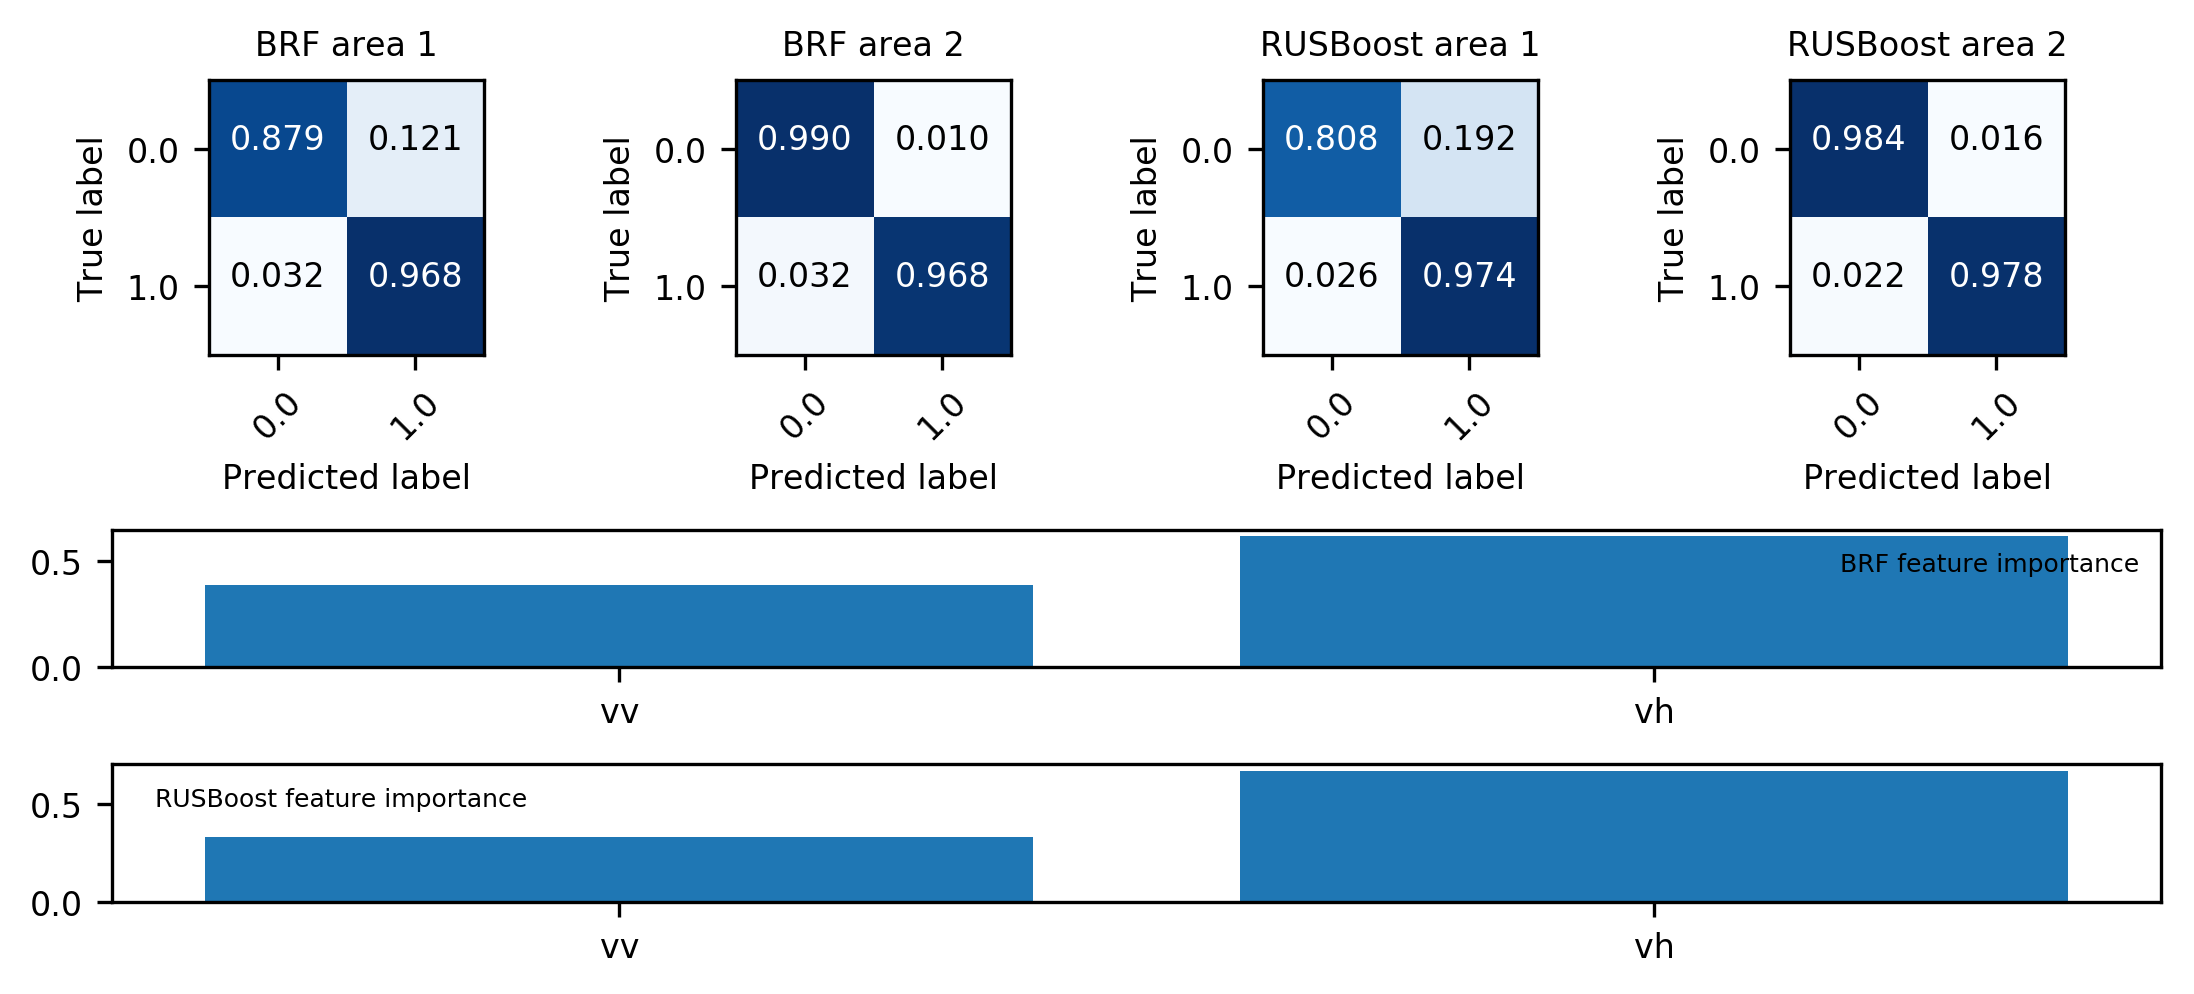

In [13]:
train_and_validate(clean_1, clean_2, feature_sets, 'base')

training sample fraction: 0.03825655356216513
water fraction: 0.06461426104242685
Balanced Random Forest classifier balanced accuracy: 0.92 - Geometric mean 0.92
Balanced Random Forest classifier balanced accuracy: 0.98 - Geometric mean 0.98
RUSBoost classifier balanced accuracy: 0.91 - Geometric mean 0.91
RUSBoost classifier balanced accuracy: 0.98 - Geometric mean 0.98


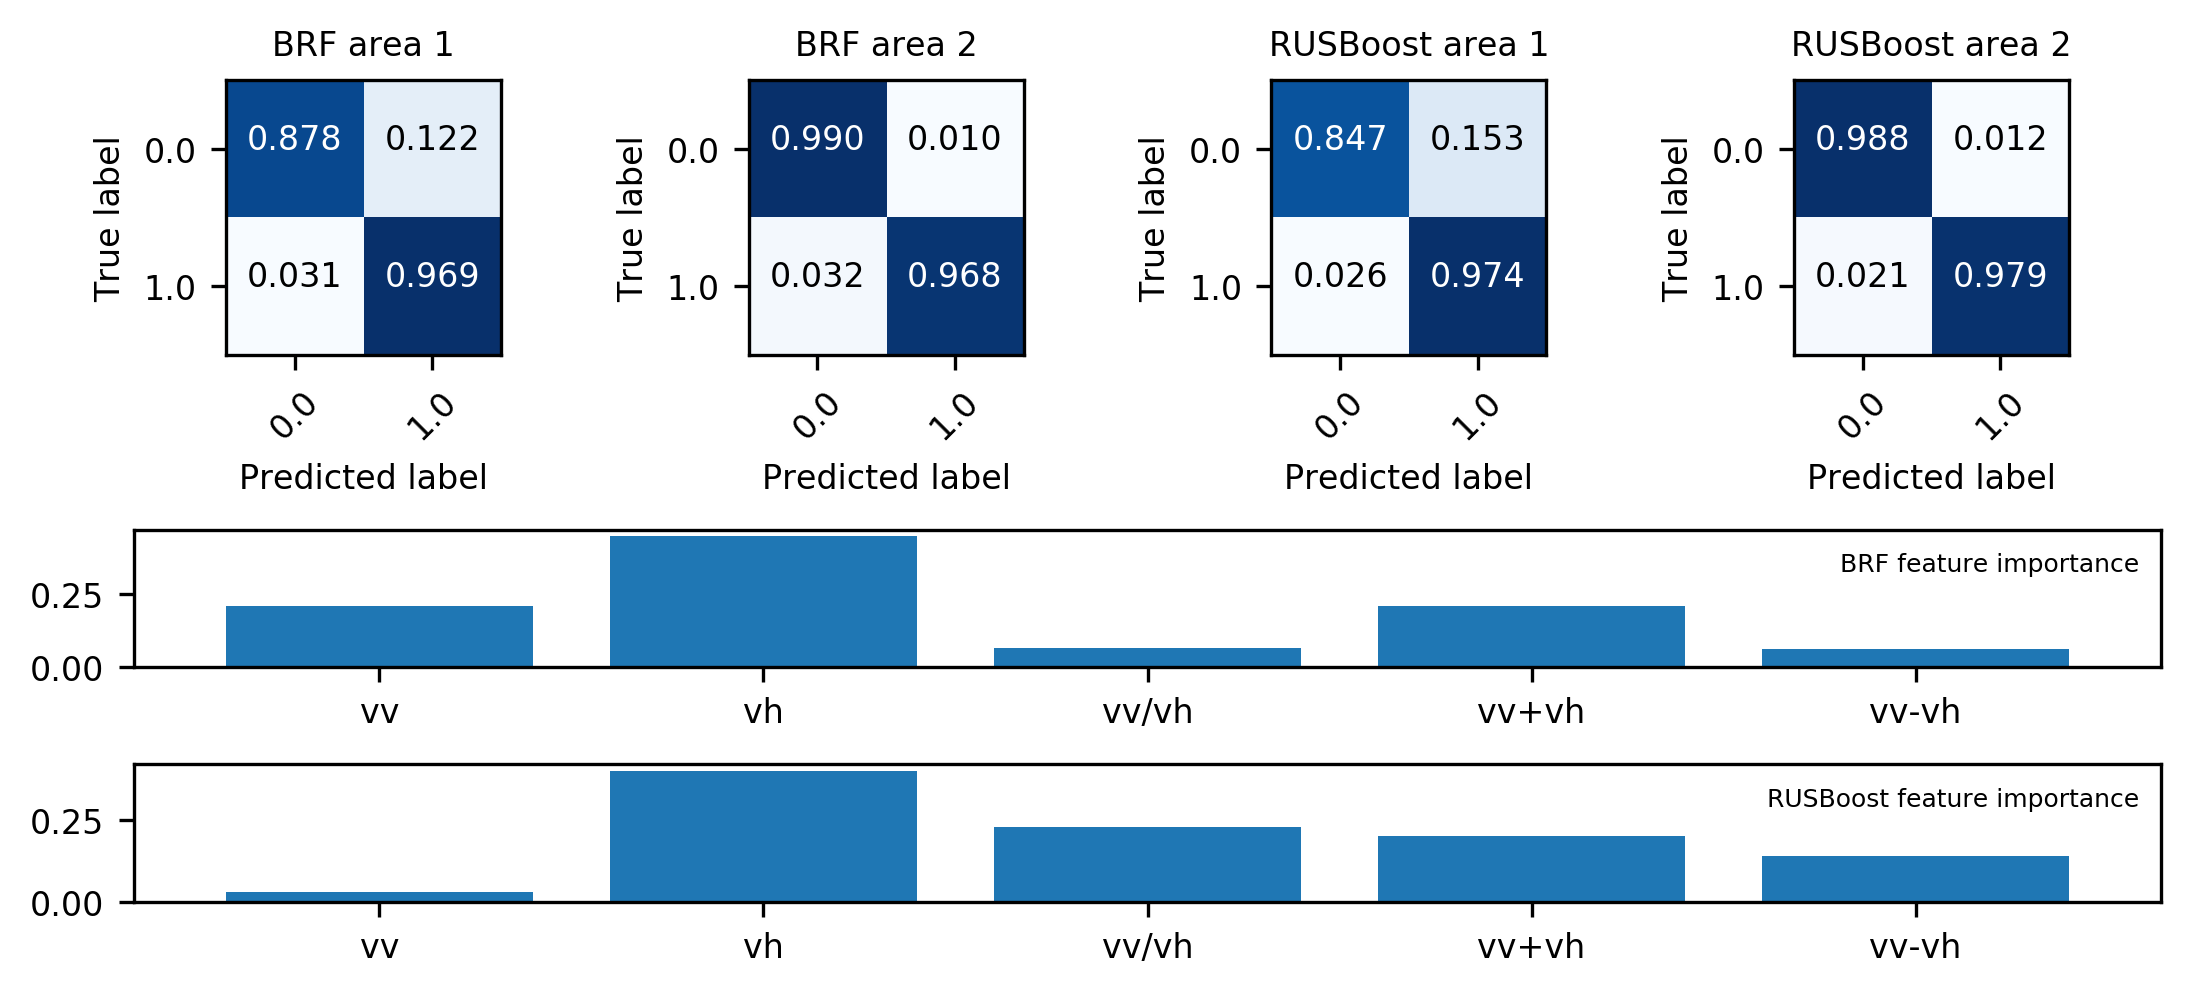

In [14]:
train_and_validate(clean_1, clean_2, feature_sets, 'ind')

training sample fraction: 0.03825655356216513
water fraction: 0.06461426104242685
Balanced Random Forest classifier balanced accuracy: 0.97 - Geometric mean 0.97
Balanced Random Forest classifier balanced accuracy: 1.00 - Geometric mean 1.00
RUSBoost classifier balanced accuracy: 0.95 - Geometric mean 0.95
RUSBoost classifier balanced accuracy: 0.99 - Geometric mean 0.99


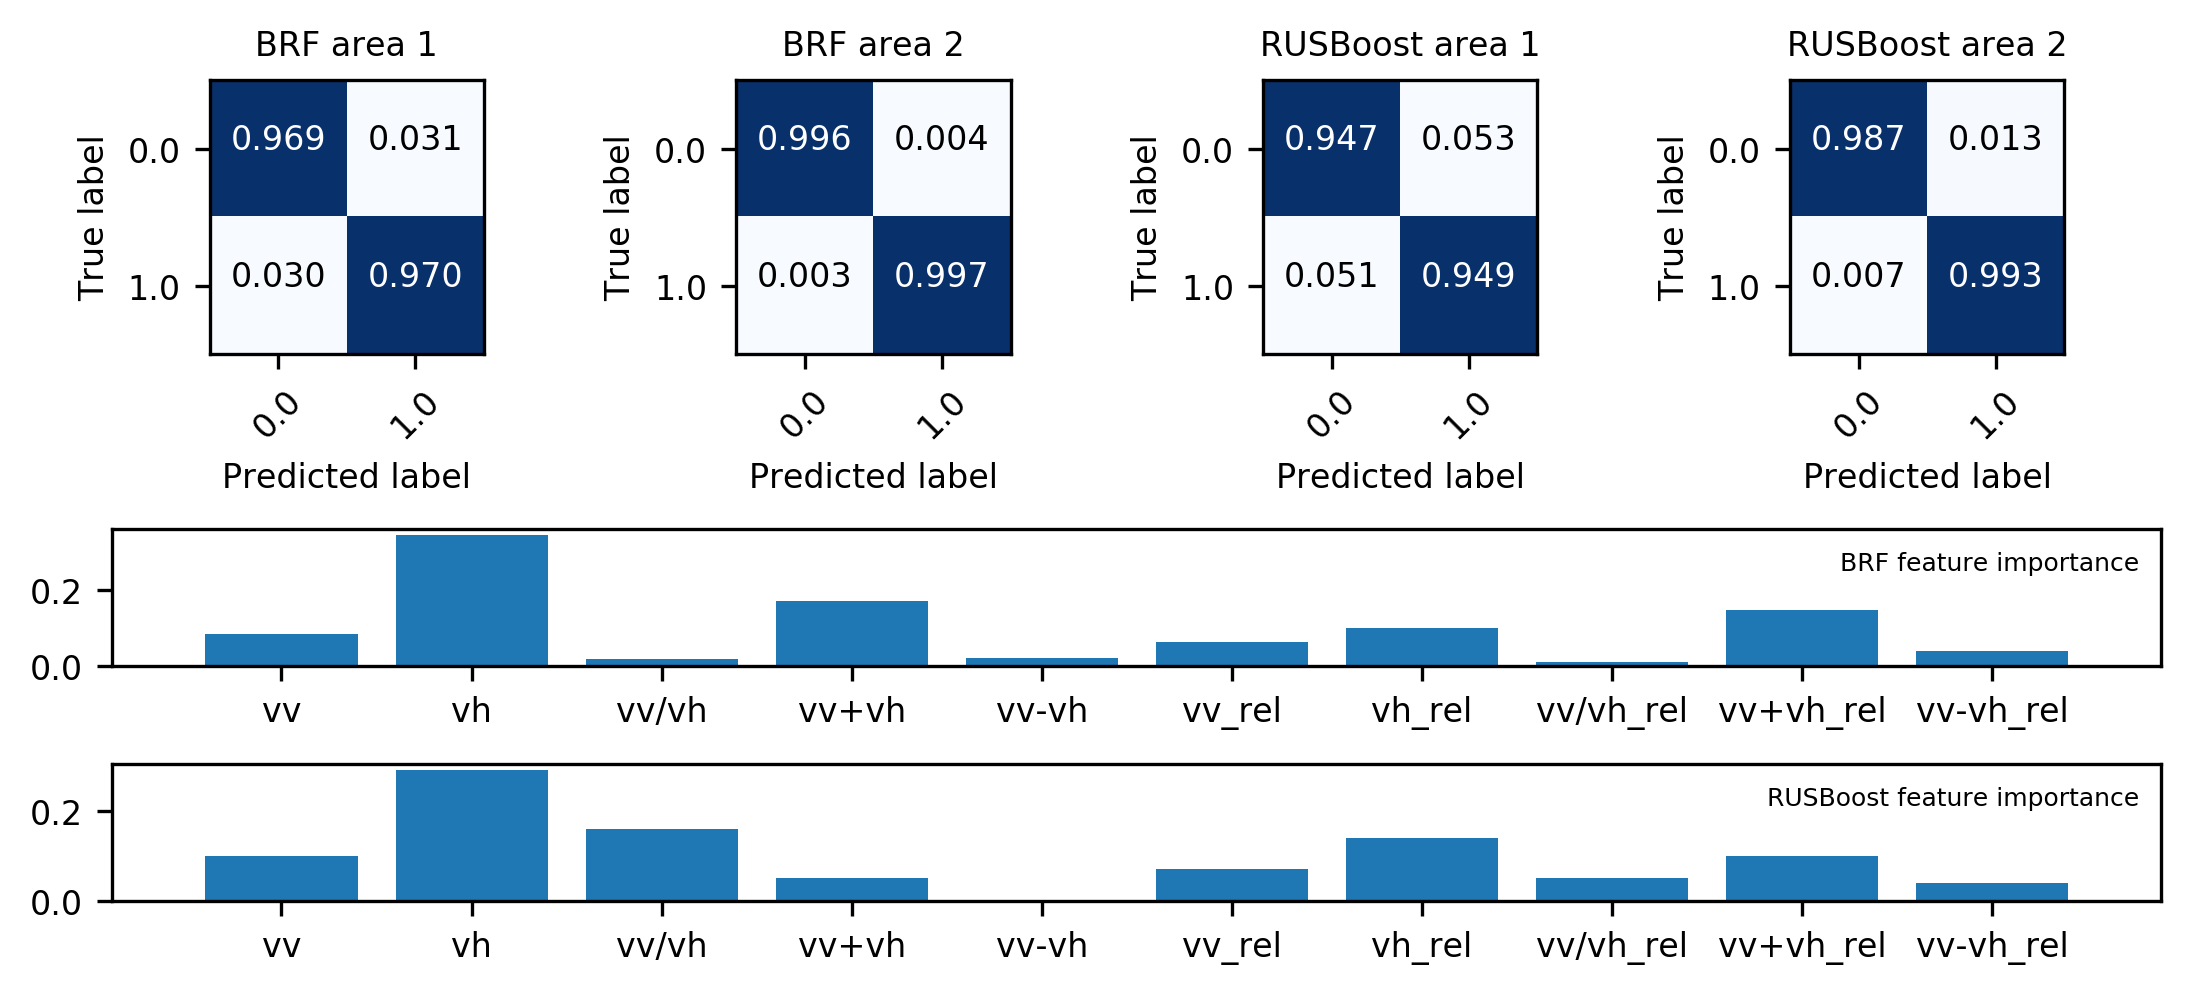

In [15]:
train_and_validate(clean_1, clean_2, feature_sets, 'rel')